In [1]:
from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
p2 = Paths("0518_p")

p4d = Pix4D(project_path=p2.pix4d_project, 
            raw_img_path=p2.raw_img, 
            project_name=p2.project_name,
            param_folder=p2.pix4d_param)

shp_file = r"Y:\hwang_Pro\data\2020_tanashi_broccoli\02_GIS\rotate_grids\split_grid_2.5m.shp"

process_area = shp.read_shp3d(shp_file, dsm_path=p4d.dsm_file, geotiff_proj=p4d.dsm_header['proj'], name_field="id", get_z_by="mean")

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200518_P4M_10m_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200518_P4M_10m_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200518_P4M_10m_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][shp][fields] Shp fields: {'id': 0, 'left': 1, 'top': 2, 'right': 3, 'bottom': 4}
[io][shp][proj] find ESRI projection file Y:\hwang_Pro\data\2020_tanashi

In [3]:
###############  
# 01_clip_raw #
###############

# please refer to 01_slice/09_project2raw.ipynb
# calculate the distance
def calculate_dist2center(p4d, geo2raw_out_dict, id_name):
    dist_container = pd.DataFrame(columns=['id', 'image', 'xc', 'yc', 'dist', 'angle', #'direction', 
                                           "select", 'roi'])
    for i, c in geo2raw_out_dict.items():
        c = np.asarray(c)
        #x0, y0 = c.mean(axis=0)
        xmin, ymin = c.min(axis=0)
        xmax, ymax = c.max(axis=0)
        roi_w = xmax - xmin
        roi_h = ymax - ymin
        x0 = (xmax+xmin)/2
        y0 = (ymax+ymin)/2
                
        if roi_w > 1500 or roi_h > 1500:
            print(f"[Warning]: plot [{id_name}] on img [{i}], roi size ({roi_w},{roi_h}) exceed (1500, 1500)")
        

        x1, y1 = 0.5 * p4d.img[i].w, 0.5 * p4d.img[i].h
        d = np.sqrt((x1-x0) ** 2 + (y1 - y0) ** 2)
        
        v1 = np.asarray([x0-x1, y0-y1])
        v0 = np.asarray([0, 1])
        
        # https://blog.csdn.net/qq_32424059/article/details/100874358
        angle = calc_angle_2(v0, v1)
        """
        if angle > 45 and angle <= 135:
            direction = 'Right'
        elif angle > 135 and angle <= 225:
            direction = "Down"
        elif angle > 225 and angle <= 315:
            direction = "Left"
        else:
            direction = "Up"
        """
        
        dist_container.loc[len(dist_container)] = {"id":id_name, "image":i, "xc":x0, "yc":y0, "dist":d, 
                                                   "angle":angle, #"direction":direction,
                                                   "select":False, "roi":c}
        dist_container['dist'] = dist_container['dist'].astype(float)

    return dist_container

def calc_angle_2(v1, v2):
    '''
    支持大于180度计算
    https://www.pythonf.cn/read/131921
    '''
    r = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2)))
    deg = r * 180 / np.pi

    a1 = np.array([*v1, 0])
    a2 = np.array([*v2, 0])

    a3 = np.cross(a1, a2)

    if np.sign(a3[2]) > 0:
        deg = 360 - deg

    return deg

def select_best(dist_container, strategy="min_dist"):
    if strategy == "min_dist":
        dist_container = dist_container.sort_values(by=['dist'], axis=0, ascending=True)
        dist_container = dist_container.reset_index()
    
        return dist_container.iloc[0:10, :]
    else:
        dist_container = dist_container.sort_values(by=['direction', 'dist'], axis=0, ascending=True)
        
        direct = ['Up', 'Right', 'Down', 'Left']

        for i, d in enumerate(direct):
            t_all = reverse_dist[reverse_dist.direction == d]
            t = t_all.iloc[0,:]
            ax.scatter(t.xc, t.yc, c=color[i])

In [6]:
result_container = pd.DataFrame(columns=['id', 'image', 'xc', 'yc', 'dist', 'angle', 
                                          "select", 'roi'])
for plot_id, roi in process_area.items():
    img_dict = geo2raw.get_img_coords_dict(p4d, roi-p4d.offset.np, method="pmat")
    
    reverse_dist = calculate_dist2center(p4d, img_dict, id_name=plot_id)
    
    selected_idx = reverse_dist.copy().sort_values(by=['dist'], axis=0, ascending=True).index[0:3]
    reverse_dist.loc[selected_idx, 'select'] = True
    
    result_container = pd.concat([result_container, reverse_dist])
    
result_container['offset_x'] = round(result_container.xc - 750).astype(np.int32)
result_container['offset_y'] = round(result_container.yc - 750).astype(np.int32)

In [7]:
result_container

,id,image,xc,yc,dist,angle,select,roi,offset_x,offset_y
0,1,DJI_0482.JPG,1471.503070,1050.479710,1482.324568,238.544967,False,"[[1017.8884837779842, 486.84575251241586], [20...",722,300
1,1,DJI_0483.JPG,1367.806110,1861.314437,1368.702630,271.562227,False,"[[912.6226301208551, 1292.3382737349925], [193...",618,1111
2,1,DJI_0484.JPG,1267.481445,2695.976884,1707.890639,300.700992,False,"[[809.7740219922628, 2129.899271388765], [1834...",517,1946
3,1,DJI_0485.JPG,1192.032543,3046.014704,1969.049376,308.360804,False,"[[736.3315598987308, 2483.8644286071813], [175...",442,2296
4,1,DJI_0487.JPG,2476.126368,2312.642055,553.448608,331.994694,True,"[[2018.2962338366244, 1747.2769771778985], [30...",1726,1563
...,...,...,...,...,...,...,...,...,...,...
7,336,DJI_0127.JPG,3301.234760,1790.076662,566.251823,93.434565,True,"[[2872.2792345545718, 1254.4189204644658], [38...",2551,1040
8,336,DJI_0128.JPG,3368.364558,992.295775,1044.804696,142.753406,False,"[[2938.0171246308055, 455.483980033069], [3899...",2618,242
9,336,DJI_0136.JPG,4479.521140,1121.361260,1879.778488,111.949427,False,"[[4048.6963782235493, 580.5321694136546], [501...",3730,371
10,336,DJI_0137.JPG,4402.697996,1904.651399,1668.648213,87.229622,False,"[[3977.0720239931406, 1372.7123757100062], [49...",3653,1155


In [8]:
csv_folder = f"{p2.root}/13_roi_on_raw/{p2.project_name}"
if not os.path.exists(csv_folder):
    os.mkdir(csv_folder)
    
result_container.to_csv(f"{csv_folder}.csv", index=False)

# read broccoli root

In [9]:
root = shapefile.Reader(f"{p2.root}/10_locate_by_cv/color_label_0417_mavic/keep_points_manual.shp")

In [26]:
points_np = np.zeros((0,2))
for i, point in enumerate(root.shapes()):
    points_np = np.vstack([points_np, np.asarray(point.points)])

In [27]:
points_np

array([[ 368062.841475  , 3956058.770185  ],
       [ 368062.92601   , 3956058.50382   ],
       [ 368060.79828   , 3956058.438425  ],
       ...,
       [ 368106.16008   , 3956016.917385  ],
       [ 368105.51251   , 3956016.76586   ],
       [ 368072.58044008, 3956009.80445732]])

ht = current polygon height `process_area[i]`

In [30]:
process_area['1'][0,2]

96.82964239742103

In [31]:
points_np3d = np.insert(points_np, 2, process_area['1'][0,2], axis=1)
points_np3d

array([[3.68062841e+05, 3.95605877e+06, 9.68296424e+01],
       [3.68062926e+05, 3.95605850e+06, 9.68296424e+01],
       [3.68060798e+05, 3.95605844e+06, 9.68296424e+01],
       ...,
       [3.68106160e+05, 3.95601692e+06, 9.68296424e+01],
       [3.68105513e+05, 3.95601677e+06, 9.68296424e+01],
       [3.68072580e+05, 3.95600980e+06, 9.68296424e+01]])

In [41]:
points_raw = geo2raw.pmatrix_calc(p4d, points_np3d-p4d.offset.np, "DJI_0482.JPG", distort_correct=True)
points_raw

array([[ 2.73340484e+03,  1.19265690e+03],
       [ 2.73271011e+03,  1.30651383e+03],
       [ 1.89916207e+03,  1.06211293e+03],
       ...,
       [ 3.62809011e+06,  6.63043694e+06],
       [ 3.42159231e+06,  6.39611008e+06],
       [-2.61384188e+05,  2.15479494e+06]])

In [38]:
from PIL import Image

In [44]:
deeplab_dict = {}
for idx, row in result_container[result_container.select].iterrows():
    original = Image.open(p4d.img[row.image].path)
    cropped = original.crop([row.offset_x, row.offset_y, row.offset_x+1500, row.offset_y+1500])
    
    points_np3d = np.insert(points_np, 2, process_area[row.id][0,2], axis=1)
    points_raw = geo2raw.pmatrix_calc(p4d, points_np3d-p4d.offset.np, row.image, distort_correct=True)
    
    points_left = points_raw[(points_raw[:,0] > row.offset_x) & (points_raw[:,0] < row.offset_x+1500) & 
                             (points_raw[:,1] > row.offset_y) & (points_raw[:,1] < row.offset_y+1500), :]
    
    print(row.image, row.id, len(points_left), end='\r')
    points_left_offset = points_left - np.asarray([[row.offset_x, row.offset_y]])
    
    #cropped.save(f"{csv_folder}/{row.id}_{row.image}")
    break

In [45]:
points_left_offset

array([[1181.86366636,  761.98597568],
       [1451.66326328,  953.8428962 ],
       [1458.96546998,  841.52668016],
       [1160.11489333,  895.95014214],
       [ 584.83293868,  785.05117623],
       [ 863.08862888,  898.06831759],
       [1418.48938865, 1102.96599302],
       [1158.69695705, 1038.9897486 ],
       [ 561.75708295,  930.35966101],
       [ 852.29364555, 1038.85831772],
       [1408.77509161, 1242.91084502],
       [1133.7238109 , 1194.79700555],
       [ 848.14345966, 1182.22128824],
       [ 553.5560905 , 1087.06649755],
       [1390.31943573, 1371.631738  ],
       [1124.41969147, 1344.35933727],
       [ 540.1379691 , 1217.13346403],
       [ 833.33317262, 1315.75382881],
       [1120.59917186, 1481.03271173],
       [ 814.9987272 , 1449.27989436],
       [ 523.13894849, 1364.28332113]])

In [49]:
points_left_offset.tolist()

[[1181.863666358, 761.9859756826454],
 [1451.663263280143, 953.8428962019343],
 [1458.9654699820198, 841.5266801579892],
 [1160.114893330474, 895.9501421369982],
 [584.8329386807859, 785.0511762335168],
 [863.088628883675, 898.0683175870295],
 [1418.489388647446, 1102.9659930177713],
 [1158.6969570490555, 1038.9897485973252],
 [561.7570829509536, 930.3596610079117],
 [852.2936455467157, 1038.8583177223636],
 [1408.7750916097739, 1242.910845017187],
 [1133.7238109026034, 1194.797005548212],
 [848.1434596563345, 1182.2212882445197],
 [553.5560904993235, 1087.0664975531345],
 [1390.3194357250404, 1371.6317379950838],
 [1124.4196914677582, 1344.3593372723908],
 [540.1379690957538, 1217.133464033695],
 [833.3331726157749, 1315.7538288131054],
 [1120.5991718598038, 1481.0327117316383],
 [814.9987272001522, 1449.2798943560028],
 [523.1389484942902, 1364.2833211311518]]

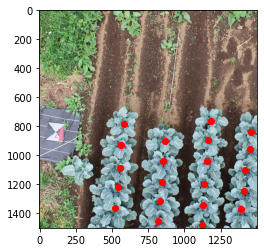

In [47]:
plt.imshow(np.asarray(cropped))
plt.scatter(*points_left_offset.T, color='r')

In [52]:
deeplab_dict = {}
for idx, row in result_container[result_container.select].iterrows():
    original = Image.open(p4d.img[row.image].path)
    cropped = original.crop([row.offset_x, row.offset_y, row.offset_x+1500, row.offset_y+1500])
    
    points_np3d = np.insert(points_np, 2, process_area[row.id][0,2], axis=1)
    points_raw = geo2raw.pmatrix_calc(p4d, points_np3d-p4d.offset.np, row.image, distort_correct=True)
    
    points_left = points_raw[(points_raw[:,0] > row.offset_x) & (points_raw[:,0] < row.offset_x+1500) & 
                             (points_raw[:,1] > row.offset_y) & (points_raw[:,1] < row.offset_y+1500), :]
    
    print(row.image, row.id, len(points_left), end='\r')
    points_left_offset = points_left - np.asarray([[row.offset_x, row.offset_y]])
    
    img_name= f"{row.id}_{row.image}"
    
    deeplab_dict[img_name] = {"imagePath": f"./{p2.project_name}/{img_name}",
                              "points": points_left_offset.tolist()}
    
    cropped.save(f"{csv_folder}/{row.id}_{row.image}")
    break

In [53]:
deeplab_dict

{'1_DJI_0487.JPG': {'imagePath': './broccoli_tanashi_5_20200518_P4M_10m/1_DJI_0487.JPG',
  'points': [[1181.863666358, 761.9859756826454],
   [1451.663263280143, 953.8428962019343],
   [1458.9654699820198, 841.5266801579892],
   [1160.114893330474, 895.9501421369982],
   [584.8329386807859, 785.0511762335168],
   [863.088628883675, 898.0683175870295],
   [1418.489388647446, 1102.9659930177713],
   [1158.6969570490555, 1038.9897485973252],
   [561.7570829509536, 930.3596610079117],
   [852.2936455467157, 1038.8583177223636],
   [1408.7750916097739, 1242.910845017187],
   [1133.7238109026034, 1194.797005548212],
   [848.1434596563345, 1182.2212882445197],
   [553.5560904993235, 1087.0664975531345],
   [1390.3194357250404, 1371.6317379950838],
   [1124.4196914677582, 1344.3593372723908],
   [540.1379690957538, 1217.133464033695],
   [833.3331726157749, 1315.7538288131054],
   [1120.5991718598038, 1481.0327117316383],
   [814.9987272001522, 1449.2798943560028],
   [523.1389484942902, 1364.

In [54]:
from easyric.io.json import dict2json

In [56]:
dict2json(deeplab_dict, f"{p2.root}/13_roi_on_raw/{p2.project_name}.json")

[io][json] Save Json file -> Y:\hwang_Pro\data\2020_tanashi_broccoli\13_roi_on_raw\broccoli_tanashi_5_20200518_P4M_10m.json


# run batch

In [57]:
deeplab_dict = {}
for idx, row in result_container[result_container.select].iterrows():
    original = Image.open(p4d.img[row.image].path)
    cropped = original.crop([row.offset_x, row.offset_y, row.offset_x+1500, row.offset_y+1500])
    
    points_np3d = np.insert(points_np, 2, process_area[row.id][0,2], axis=1)
    points_raw = geo2raw.pmatrix_calc(p4d, points_np3d-p4d.offset.np, row.image, distort_correct=True)
    
    points_left = points_raw[(points_raw[:,0] > row.offset_x) & (points_raw[:,0] < row.offset_x+1500) & 
                             (points_raw[:,1] > row.offset_y) & (points_raw[:,1] < row.offset_y+1500), :]
    
    print(row.image, row.id, len(points_left), end='\r')
    points_left_offset = points_left - np.asarray([[row.offset_x, row.offset_y]])
    
    img_name= f"{row.id}_{row.image}"
    
    deeplab_dict[img_name] = {"imagePath": f"./{p2.project_name}/{img_name}",
                              "points": points_left_offset.tolist()}
    
    cropped.save(f"{csv_folder}/{row.id}_{row.image}")

dict2json(deeplab_dict, f"{p2.root}/13_roi_on_raw/{p2.project_name}.json")

[io][json] Save Json file -> Y:\hwang_Pro\data\2020_tanashi_broccoli\13_roi_on_raw\broccoli_tanashi_5_20200518_P4M_10m.json
